In [10]:
import pandas as pd
import numpy as np

import os
import glob
import re

from matplotlib import pyplot as plt
import seaborn as sns

In [11]:
##data
input_fps = ['./example_data/0p8M.csv',
             './example_data/1M.csv']
parameter_column = 'Concentration'
time_column = None

In [12]:
print('Available models:')
for fn in glob.glob('checkpoints/*degradation4*'):
    if not '4var' in fn and not 'scaler' in fn:
        fn = fn.split('/')[-1]
        windows = re.findall(r'_\d+_\d+_',fn)[0]
        input_window=windows.split('_')[1]
        forecast_window = windows.split('_')[2]
        print(f'\tInput Window={input_window}, Prediction Window={forecast_window}')

Available models:
	Input Window=375, Prediction Window=1000
	Input Window=375, Prediction Window=2000


In [13]:
##model
input_window=375
prediction_window=2000

In [14]:
for path in [f'./dataset',f'./dataset/ROVI/',f'./dataset/ROVI/pred/']:
    if not os.path.exists(path):
        os.mkdir(path)

In [15]:
#reformat data files for input to iTransformer model
fns = []
for fp in input_fps:
    df = pd.read_csv(fp)

    fn = fp.split('/')[-1]

    norm_value = df[parameter_column].values[0]
    df['OT'] = df[parameter_column]/norm_value

    if time_column is None:
        df['timestamp'] = pd.date_range(start='2024-12-18 13:09:16.959331',freq='24H',periods=len(df))
    else:
        df['timestamp'] = pd.to_datetime(df[time_column])

    out_fp = f'./dataset/ROVI/pred/{fn}'
    df.to_csv(out_fp,index=False)
    fns.append(out_fp)

In [16]:
#!mkdir results
!sh ./scripts/long_term_forecast/ROVI_script/Transformer_ROVI_predict.sh $input_window $prediction_window

False
Args in experiment:
Basic Config
  Task Name:          ROVI_forecast       Is Training:        0                   
  Model ID:           ROVI_forecast_degradation4_375_2000_iTransformer_1D_ftM_sl375_ll0_pl2000_dm32_nh4_el3_dl3_df128_expand2_dc4_fc1_ebtimeF_dtTrue_lr0.001_do0.0_patience20_Exp_0Model:              iTransformer        

Data Loader
  Data:               1D                  Root Path:          ./dataset/ROVI/     
  Data Path:          ETTh1.csv           Features:           M                   
  Target:             OT                  Freq:               h                   
  Checkpoints:        ./checkpoints/      

Model Parameters
  Top k:              5                   Num Kernels:        6                   
  Enc In:             7                   Dec In:             7                   
  C Out:              7                   d model:            32                  
  n heads:            4                   e layers:           3                   
  d

In [17]:
def load_data(path):
    
    true = np.load(f'{path}/real_true.npy')
    preds = np.load(f'{path}/real_prediction.npy')
    x = np.load(f'{path}/real_x.npy')
    ids = np.load(f'{path}/real_ids.npy')
    
    return true, preds, x, ids

colors= sns.color_palette()

def find_zero_index(arr):
    # Iterate over the array to find the earliest possible index
    for i in range(len(arr)):
        if arr[i] < 1e-7 and np.all(arr[i:] < 1e-7):
            return i
    return -1

def plot_curves(true, preds, x, title=None):
    
    input_cycles = range(len(x))
    pred_cycles = range(len(x),len(x)+len(preds))

    
    zero_idx = find_zero_index(true)
    idx = np.ones(len(true)).astype(bool)
    if zero_idx != -1:
        idx[zero_idx:]=False
    
    true = true[idx]
    true_cycles = range(len(x),len(x)+len(true))
    
    sns.set_context("talk")
    plt.plot(input_cycles,x,color=colors[0])
    plt.plot(true_cycles, true,color=colors[0],label='True')
    plt.scatter([pred_cycles[0]],[preds[0]],color=colors[2],marker='o',zorder=10,s=18)
    plt.plot(pred_cycles, preds,color=colors[2],label='Predicted')
    plt.legend()
    plt.xlabel('Cycle')
    plt.ylabel('Parameter')
    if not title is None:
        plt.title(title)
    plt.show()
    

In [18]:
true, preds, x, ids = load_data('results/ROVI_forecast_degradation4_375_2000_iTransformer_1D_ftM_sl375_ll0_pl2000_dm32_nh4_el3_dl3_df128_expand2_dc4_fc1_ebtimeF_dtTrue_lr0.001_do0.0_patience20_Exp_0')

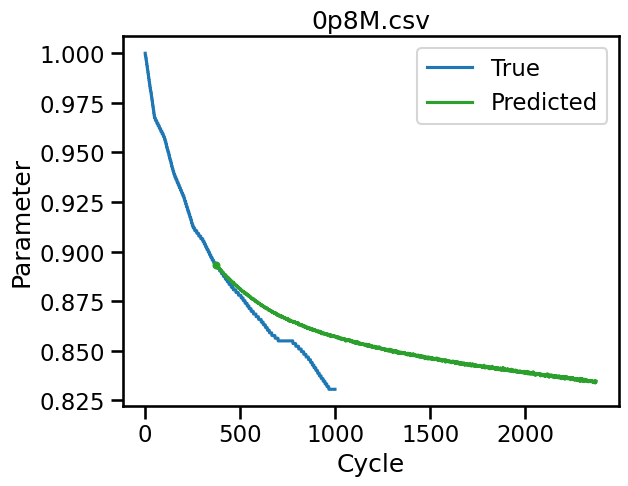

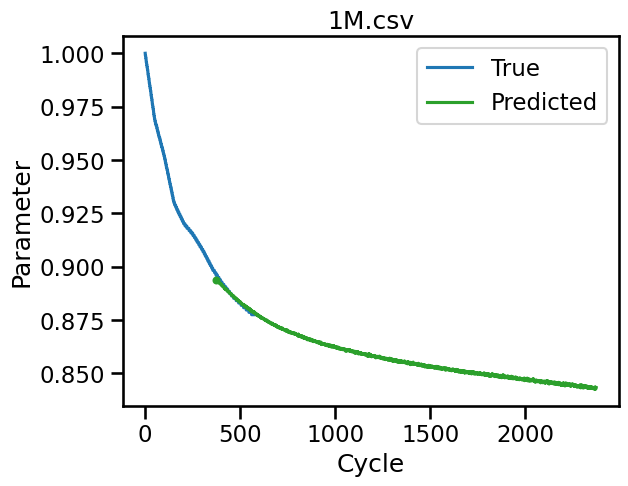

In [19]:
for i in range(len(true)):
    plot_curves(true[i],preds[i],x[i],title=ids[i])